# Import dependencies

In [1]:
'''
from google.colab import drive
drive.mount('/content/drive')

! pip install -q condacolab
import condacolab
condacolab.install()

! conda create -n fenicsx-env
! conda activate fenicsx-env
! conda install -c conda-forge fenics-dolfinx mpich pyvista

! pip install cffi==1.17.1
%cd /content/drive/MyDrive/Masterarbeit/TGV-regulairzed-wave-equation/python/
'''

import numpy as np
import scipy
from typing import List
import matplotlib as mpl
from dolfinx import fem, mesh
from dataclasses import dataclass
from mpi4py import MPI
from src.solutionOperators import getSourceTerm, solveStateEquation, buildControlFunction, solveAdjointEquation, buildControlFunctionAdjoint
from src.visualization import plot_array, printIterationInfo, timeDependentVariableToGif
from src.ExtremalPoints import ExtremalPoint
from src.HesseMatrix import HesseMatrix
from src.osqp import computeOSQPStep
from src.iterationHelpers import pruneActiveSet, calculateDiscreteGradient,\
    integrateVectorFunction, getIdxMax, calculateFirstDual, calculateSecondDual, showNonStationarity
from src.helpers import buildIterationFunction, computeObjective, linCombFunctionLists, calculateL2InnerProduct
from src.semiSmoothNewtonSolver import computeSSNStep
from src.semiSmoothWalter import computeSSNStepWalter

# Set parameters

In [2]:
@dataclass
class Parameters:
    T = 1
    verbose = True
    useDummy = False
    dt = 0.01
    x1 = (0.5, 0.5)
    x2 = (-0.5, -0.5)
    area = 4
    d = 2
    mollify_const = 0.1
    alpha = 2e-9
    beta = 1e-7
    waveSpeed = 1
    randomFactor = 5
    maxIterations = 50
    pruneThreshold = 0
    maxNewtonSteps = 50
    newton_c = 5
    yd = []
    yd_adjoint = []
    yd_firstDual = None
    yd_secondDual = None
    standardInnerProducts = None
    solver = computeSSNStep
    msh = mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=((-1., -1.), (1., 1.)),
        n=(64, 64),
        cell_type=mesh.CellType.triangle,
    )
    V = fem.functionspace(msh, ("Lagrange", 1))

params = Parameters()

# Setup problem

In [3]:
def setupObservation(s1, s2, params):
	g1 = getSourceTerm(params.x1, params)
	g2 = getSourceTerm(params.x2, params)
	control = buildControlFunction([g1, g2], [s1, s2], params)
	if not params.useDummy:
		K_u = solveStateEquation(control, params)
	else:
		K_u = control
	grid_size = K_u[0].x.array.shape
	raw_matrices = [K_u_t.x.array for K_u_t in K_u]
	norms = [np.linalg.norm(matrix, ord=2) for matrix in raw_matrices]
	scale = params.randomFactor * np.mean(norms) / grid_size[0] * params.area
	np.random.seed(42)
	yd = [fem.Function(params.V) for _ in K_u]
	for idx in range(len(yd)):
		yd[idx].x.array[:] = K_u[idx].x.array + np.random.normal(loc=0.0, scale=scale, size=grid_size)
	params.yd = yd
	params.yd_inner = calculateL2InnerProduct(params.yd,params.yd, params)
	if not params.useDummy:
		params.yd_adjoint = solveAdjointEquation(params.yd, params)
	else:
		params.yd_adjoint = params.yd
	raw_data = np.array([func.x.array for func in params.yd])
	timePoints = np.linspace(0, params.T, num=len(params.yd))
	integrated_raw_data = scipy.integrate.cumulative_simpson(raw_data, x=timePoints, axis=0, initial=0)
	second_integrated_raw_data = scipy.integrate.cumulative_simpson(integrated_raw_data, x=timePoints, axis=0, initial=0)
	params.yd_dual = [fem.Function(params.V) for _ in params.yd]
	params.yd_second_dual = [fem.Function(params.V) for _ in params.yd]
	for idx, (func1, func2) in enumerate(zip(params.yd_dual, params.yd_second_dual)):
		func1.x.array[:] = integrated_raw_data[idx]
		func2.x.array[:] = second_integrated_raw_data[idx]
	#if not params.useDummy:
	#	params.yd_dual_adjoint = solveAdjointEquation(params.yd_dual, params)
	#	params.yd_second_dual_adjoint = solveAdjointEquation(params.yd_second_dual, params)
	#else:
	#	params.yd_dual_adjoint = params.yd_dual
	#	params.yd_second_dual_adjoint = params.yd_second_dual


# Minimization algorithm

In [4]:
def algorithm(active_set_init, weights_init, slope_init, y_shift_init, params: Parameters):
	active_set = []
	active_set[:] = active_set_init
	hesse = HesseMatrix(active_set, params)
 
	if params.verbose:
		print('Objective upper bound: ', computeObjective(np.concatenate((weights_init, slope_init, y_shift_init)), active_set_init, hesse.standard_states, hesse, params))
	weights = np.copy(weights_init)
	slope = np.copy(slope_init)
	y_shift = np.copy(y_shift_init)
	constraintViolation = np.empty(params.maxIterations)
	sizeActiveSet = np.empty(params.maxIterations)
	sizeActiveSet[:] = np.nan
	constraintViolation[:] = np.nan
	weights, slope, y_shift = params.solver(weights, slope, y_shift, active_set, hesse, params)
	if params.verbose:
		print('weights: ', weights, 'slope: ', slope, 'y_shift', y_shift)
		print('Objective: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, hesse, params))
	timePoints = np.linspace(0, params.T, num=len(params.yd))

	for k in range(params.maxIterations):
		discreteDf = calculateDiscreteGradient(active_set, weights, slope, y_shift, hesse, params)
		if params.verbose:
			printIterationInfo(k, active_set, weights, slope, y_shift, hesse.matrix)
			showNonStationarity(discreteDf, active_set, params)
		p_k = integrateVectorFunction(discreteDf, params)
		#p_k = p_k - np.array([t**2 * p_k[-1,:] / params.T**2 for t in timePoints])
		#p_k_old = calculateFirstDual(active_set, weights, slope, y_shift, hesse, params)
		#P_k = -integrateVectorFunction(p_k, params)
		#P_k_old = calculateSecondDual(active_set, weights, slope, y_shift, hesse, params)
		P_k = integrateVectorFunction(discreteDf * timePoints[:, np.newaxis], params) - p_k * timePoints[:, np.newaxis]
		#P_k = P_k - np.array([t**2 * P_k[-1,:] / params.T**2 for t in timePoints])
		if params.verbose:
			u_k = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)
			print('Boundary values of duals: ', p_k[-1,:]/params.alpha, P_k[-1,:]/params.beta)
			_, (ax1, ax2, ax3, ax4) = mpl.pyplot.subplots(1, 4, figsize=(20, 5))
			plot_array(discreteDf, params.T, label='grad', ax=ax1)
			ax2.plot(timePoints, p_k/params.alpha, linestyle='-', color='b', label='|p_k|/alpha')
			ax3.plot(timePoints, P_k/params.beta, linestyle='-', color='b', label='|P_k|/beta')
			ax2.grid(True), ax3.grid(True)
			plot_array(np.array([u_k(t) for t in timePoints]), params.T, label='iteration function', ax=ax4)
			mpl.pyplot.show()

		idx_S = getIdxMax(p_k, active_set, type=0)
		idx_K = getIdxMax(P_k, active_set, type=1)
		norm_p_max = np.linalg.norm(p_k[idx_S])
		norm_P_max = np.linalg.norm(P_k[idx_K])
		if params.verbose:
			print('|p_max|/alpha: ', norm_p_max / params.alpha,  ', |P_max|/beta: ', norm_P_max / params.beta)
		constraintViolation[k] = max(norm_p_max / params.alpha, norm_P_max / params.beta) - 1
		sizeActiveSet[k] = len(active_set)
		if (max(norm_p_max / params.alpha, norm_P_max / params.beta) <= 1):
			break
		if norm_p_max / params.alpha >= norm_P_max / params.beta:
			new_sigma = p_k[idx_S] / norm_p_max
			new_x_0 = idx_S * params.dt
			new_type = 0
		else:
			new_sigma = P_k[idx_K] / norm_P_max
			new_x_0 = idx_K * params.dt
			new_type = 1
		active_set.append(ExtremalPoint(new_sigma, new_x_0, type=new_type, params=params))
		if params.verbose:
			print('x_S: ', idx_S * params.dt, 'x_K: ', idx_K * params.dt, '\nNew point: sigma=', active_set[-1].sigma, 'x_0 =', active_set[-1].x_0, ', type =', active_set[-1].type)
		hesse.extendMatrix(active_set[-1])
		weights, slope, y_shift = params.solver(np.concatenate((weights, np.array([1.]))), slope, y_shift, active_set, hesse, params)
		if params.verbose:
			print('weights: ', weights, 'slope: ', slope, 'y_shift', y_shift)
		# check double time in idx_double
		# if (double index))
		# weight_comb_new = weights[idx_double] * active_set[idx_double].sigma + weights[-1] * active_set[-1].sigma
		# weight_new = np.linalg.norm(weight_comb_new)
		# if (weight_new > 0)
		# active_set.append(ExtremalPoint(weight_comb_new/weight_new, new_x_0, type=new_type, params=params))
		active_set, weights = pruneActiveSet(active_set, weights, params.pruneThreshold)
		hesse.pruneMatrix(active_set, weights)
		#if params.verbose:
		#	print('Objective: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, hesse, params))

	u_k = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)
	fig, (ax1, ax2, ax3, ax4) = mpl.pyplot.subplots(1, 4, figsize=(20, 5))
	plot_array(discreteDf, params.T, label='grad', ax=ax1)
	ax2.plot(timePoints, np.linalg.norm(p_k, axis=1)/params.alpha,  linestyle='-', color='b', label='|p_k|/alpha')
	ax3.plot(timePoints, np.linalg.norm(P_k, axis=1)/params.beta, linestyle='-', color='b', label='|P_k|/beta')
	plot_array(np.array([u_k(t) for t in timePoints]), params.T, label='iteration function', ax=ax4)
	mpl.pyplot.show()
	printIterationInfo(k, active_set, weights, slope, y_shift, hesse.matrix)
	showNonStationarity(discreteDf, active_set, params)
	return active_set, weights, slope, y_shift, constraintViolation, sizeActiveSet


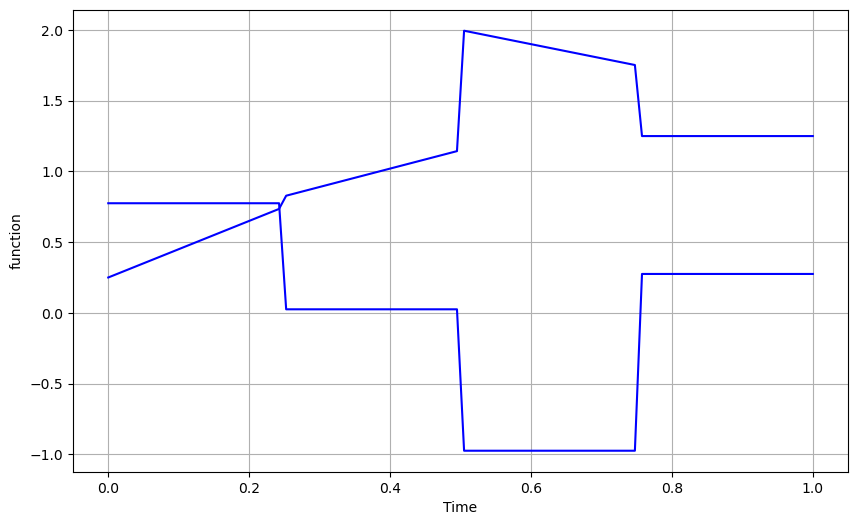

Test for alpha= 7e-09 , beta= 1e-09
Objective upper bound:  3.4695941591928036e-06
weights:  [] slope:  [ 2.12309823 -2.3816184 ] y_shift [0.26361282 0.9398017 ]
Objective:  1.507460364462587e-07
0 : Active set:
slope:  [ 2.12309823 -2.3816184 ] y_shift [0.26361282 0.9398017 ]
0 : Hesse condition: 59.34669138146474
First conditions:  [ 2.33263969e-09 -3.80941783e-09  3.59205345e-09 -4.96219039e-09]  (should be close to 0)
Second conditions:  []  (should be greater or equal than 0)
Boundary values of duals:  [ 0.51315049 -0.70888434] [-1.25941376  1.15277257]


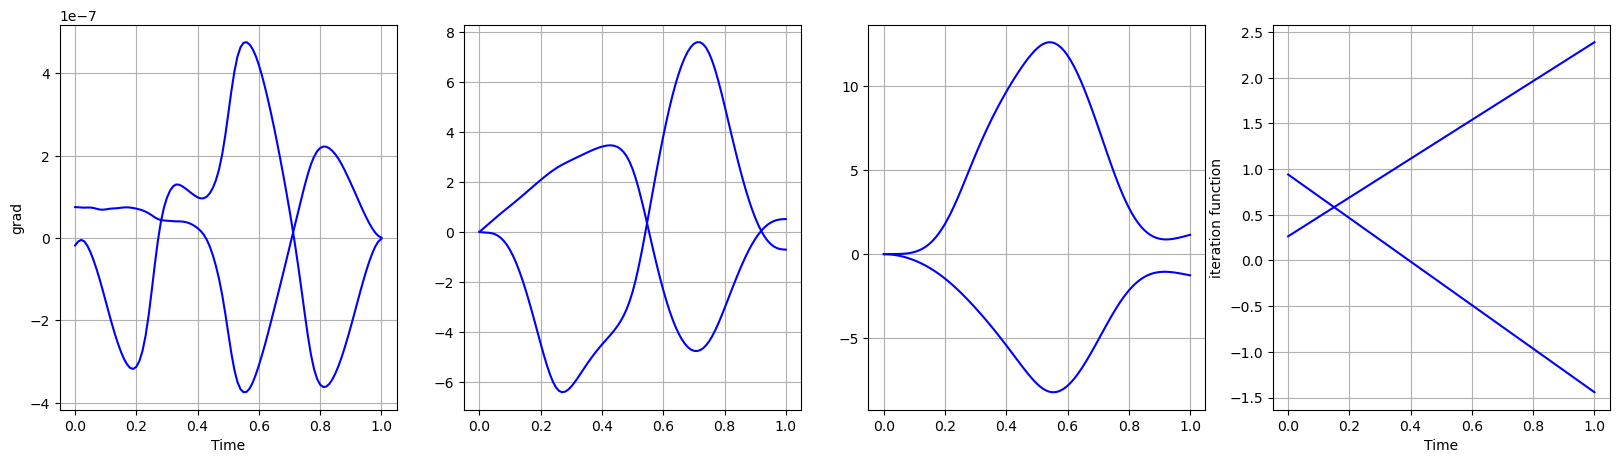

|p_max|/alpha:  8.960397475124777 , |P_max|/beta:  15.037314497808097
x_S:  0.71 x_K:  0.55 
New point: sigma= [-0.54623822  0.83762987] x_0 = 0.55 , type = 1
weights:  [5.35829207] slope:  [ 2.74254987 -3.32575086] y_shift [0.12973995 1.14251367]
1 : Active set:
	 0 sigma= [-0.54623822  0.83762987] ,	x_0 = 0.55 ,	type = 1 	weight: 5.358292071897369 	id: 140198480337504
slope:  [ 2.74254987 -3.32575086] y_shift [0.12973995 1.14251367]
1 : Hesse condition: 1919.050721611856
First conditions:  [ 6.60020029e-10 -1.21322113e-09  3.18726156e-10  1.51583076e-10]  (should be close to 0)
Second conditions:  [1.]  (should be greater or equal than 0)
Boundary values of duals:  [0.04553231 0.02165473] [ 0.34129387 -1.36480421]


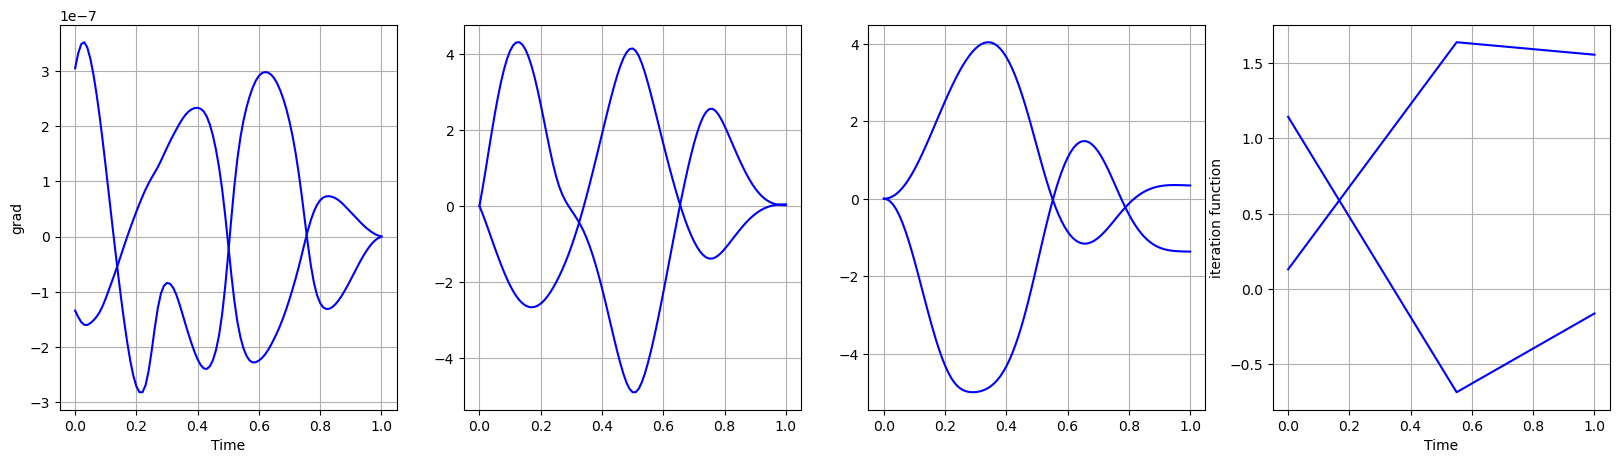

|p_max|/alpha:  6.41549833793653 , |P_max|/beta:  6.365666115809641
x_S:  0.5 x_K:  0.32 
New point: sigma= [ 0.64608563 -0.76326494] x_0 = 0.5 , type = 0
weights:  [7.02699084 0.92420388] slope:  [ 1.98871406 -2.50260752] y_shift [0.25836525 1.00505326]
2 : Active set:
	 0 sigma= [-0.54623822  0.83762987] ,	x_0 = 0.55 ,	type = 1 	weight: 7.026990841540374 	id: 140198480337504
	 1 sigma= [ 0.64608563 -0.76326494] ,	x_0 = 0.5 ,	type = 0 	weight: 0.9242038770418763 	id: 140198478886624
slope:  [ 1.98871406 -2.50260752] y_shift [0.25836525 1.00505326]
2 : Hesse condition: 2260.2149172435797
First conditions:  [ 3.59118129e-10 -6.71970322e-10  6.49844456e-10  1.41765937e-10]  (should be close to 0)
Second conditions:  [1.         0.99999999]  (should be greater or equal than 0)
Boundary values of duals:  [0.09283492 0.02025228] [-0.29072633 -0.81373626]


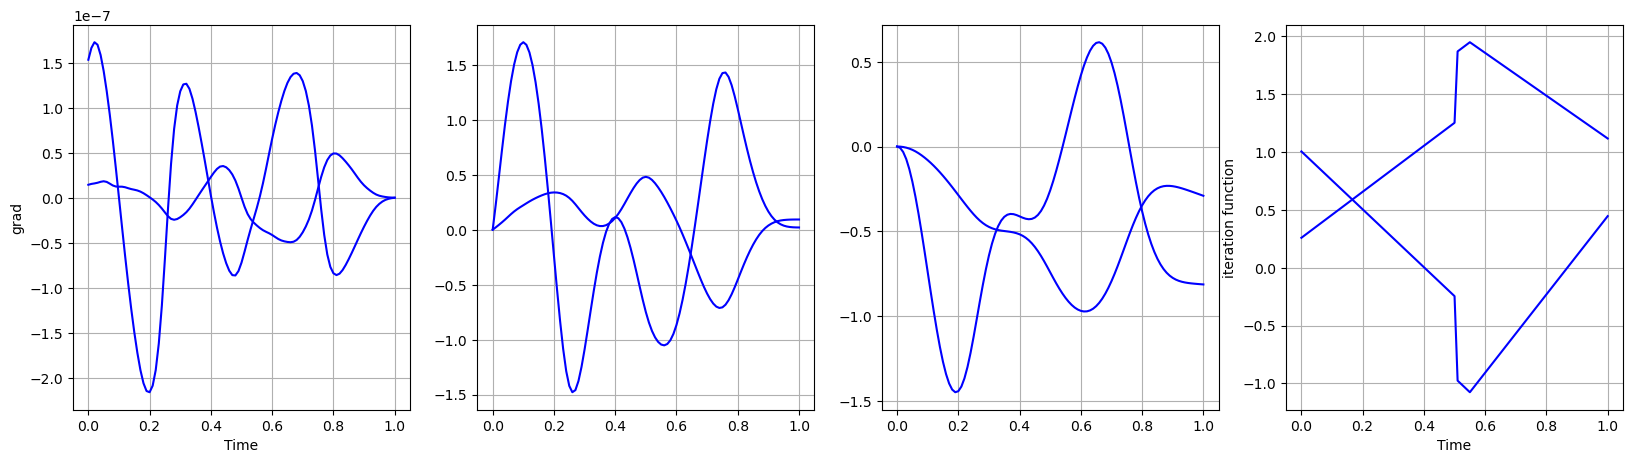

|p_max|/alpha:  1.7205619584341807 , |P_max|/beta:  1.47313973522501
x_S:  0.1 x_K:  0.19 
New point: sigma= [0.12933423 0.99160106] x_0 = 0.1 , type = 0
weights:  [7.15021445 0.89461869 0.08097805] slope:  [ 2.02356384 -2.6294129 ] y_shift [0.2444559  0.97242951]
3 : Active set:
	 0 sigma= [-0.54623822  0.83762987] ,	x_0 = 0.55 ,	type = 1 	weight: 7.15021444922743 	id: 140198480337504
	 1 sigma= [ 0.64608563 -0.76326494] ,	x_0 = 0.5 ,	type = 0 	weight: 0.8946186878621253 	id: 140198478886624
	 2 sigma= [0.12933423 0.99160106] ,	x_0 = 0.1 ,	type = 0 	weight: 0.08097804727397173 	id: 140198477552416
slope:  [ 2.02356384 -2.6294129 ] y_shift [0.2444559  0.97242951]
3 : Hesse condition: 4011.508562015186
First conditions:  [ 2.93810313e-10 -7.17269538e-10  4.68113330e-10 -1.17605925e-10]  (should be close to 0)
Second conditions:  [1.         0.99999999 0.99999999]  (should be greater or equal than 0)
Boundary values of duals:  [ 0.06687333 -0.01680085] [-0.17430302 -0.59966361]


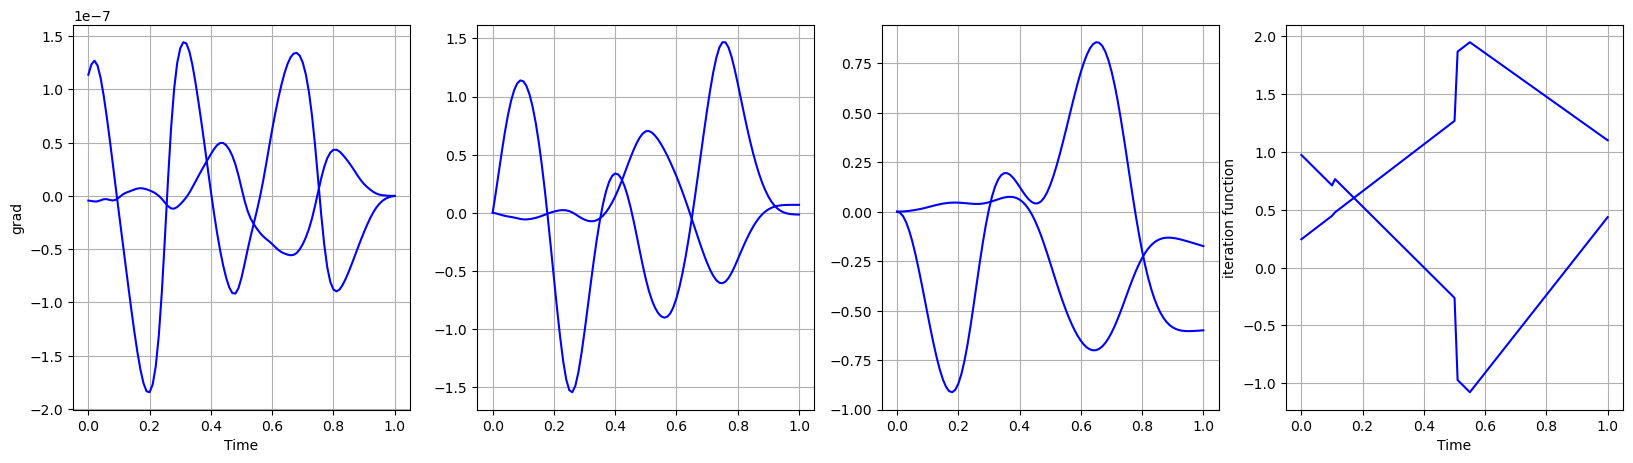

|p_max|/alpha:  1.5889401840757043 , |P_max|/beta:  1.105499197314041
x_S:  0.75 x_K:  0.65 
New point: sigma= [-0.38299768  0.92374931] x_0 = 0.75 , type = 0
weights:  [4.86355831 0.73286509 0.10994667 0.71504112] slope:  [ 2.04029965 -2.7286829 ] y_shift [0.24207937 0.97026007]
4 : Active set:
	 0 sigma= [-0.54623822  0.83762987] ,	x_0 = 0.55 ,	type = 1 	weight: 4.8635583090774155 	id: 140198480337504
	 1 sigma= [ 0.64608563 -0.76326494] ,	x_0 = 0.5 ,	type = 0 	weight: 0.7328650922486905 	id: 140198478886624
	 2 sigma= [0.12933423 0.99160106] ,	x_0 = 0.1 ,	type = 0 	weight: 0.10994667013298226 	id: 140198477552416
	 3 sigma= [-0.38299768  0.92374931] ,	x_0 = 0.75 ,	type = 0 	weight: 0.7150411210360124 	id: 140198477547760
slope:  [ 2.04029965 -2.7286829 ] y_shift [0.24207937 0.97026007]
4 : Hesse condition: 19994.5824602737
First conditions:  [ 4.52446549e-10 -5.62565513e-10  7.06002838e-10  1.00311484e-10]  (should be close to 0)
Second conditions:  [1.         0.99999999 0.99999999

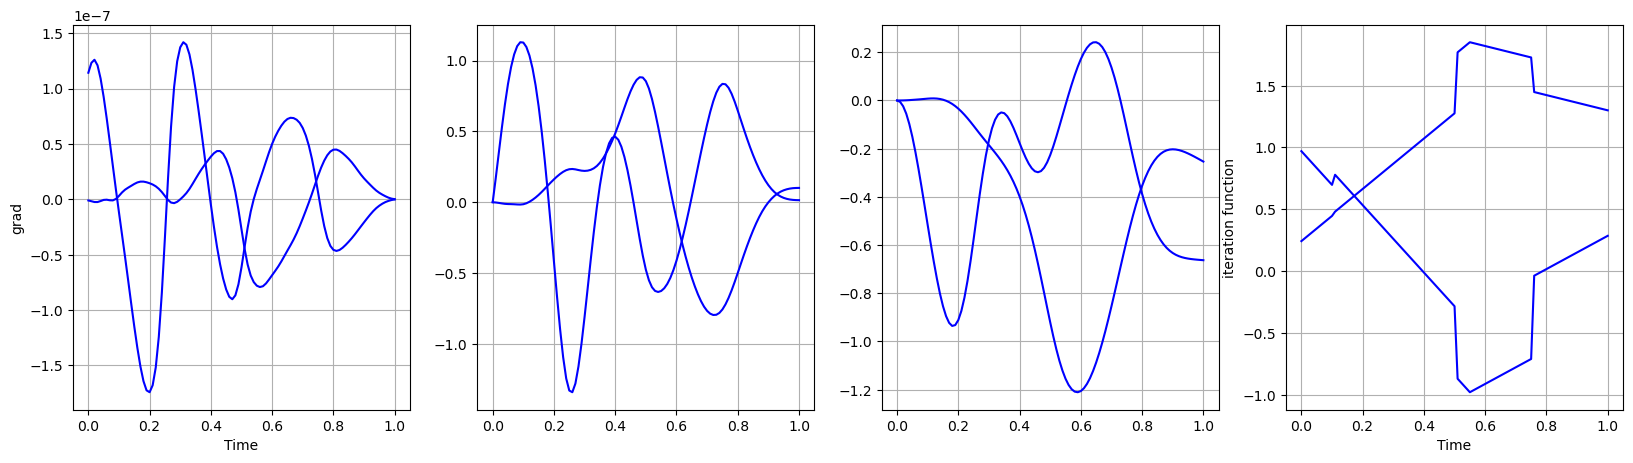

|p_max|/alpha:  1.3618221039630551 , |P_max|/beta:  1.2189055480254019
x_S:  0.26 x_K:  0.59 
New point: sigma= [ 0.17218037 -0.98506544] x_0 = 0.26 , type = 0
weights:  [4.59882616 0.79056356 0.10397541 0.67774871 0.12745316] slope:  [ 1.90603736 -2.36493385] y_shift [0.26158276 0.94344821]
5 : Active set:
	 0 sigma= [-0.54623822  0.83762987] ,	x_0 = 0.55 ,	type = 1 	weight: 4.598826164301265 	id: 140198480337504
	 1 sigma= [ 0.64608563 -0.76326494] ,	x_0 = 0.5 ,	type = 0 	weight: 0.7905635613580384 	id: 140198478886624
	 2 sigma= [0.12933423 0.99160106] ,	x_0 = 0.1 ,	type = 0 	weight: 0.1039754143953053 	id: 140198477552416
	 3 sigma= [-0.38299768  0.92374931] ,	x_0 = 0.75 ,	type = 0 	weight: 0.6777487133678738 	id: 140198477547760
	 4 sigma= [ 0.17218037 -0.98506544] ,	x_0 = 0.26 ,	type = 0 	weight: 0.12745315785810662 	id: 140198477287920
slope:  [ 1.90603736 -2.36493385] y_shift [0.26158276 0.94344821]
5 : Hesse condition: 24442.283190226113
First conditions:  [ 5.37007159e-10 -5.

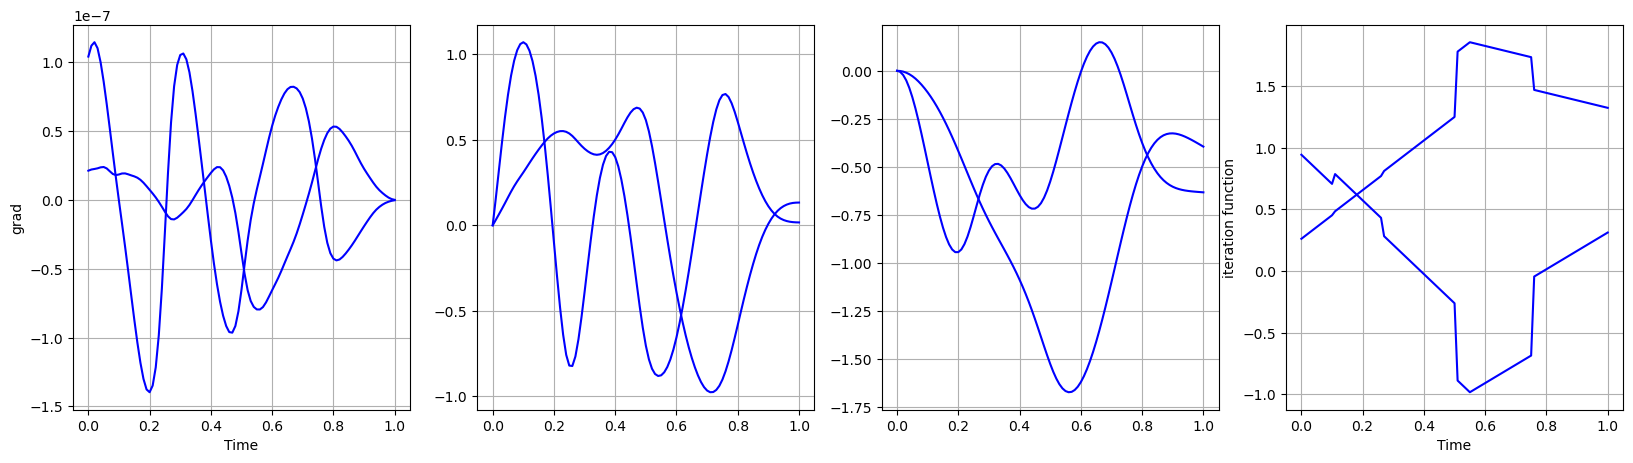

|p_max|/alpha:  1.189836928997396 , |P_max|/beta:  1.6902577629628484
x_S:  0.74 x_K:  0.55 
New point: sigma= [-0.98574164 -0.16826592] x_0 = 0.55 , type = 1
weights:  [3.9104115  0.82484939 0.05978525 0.74783237 0.19870465 0.48993374] slope:  [ 1.88743361 -2.0482085 ] y_shift [0.26399339 0.93449621]
6 : Active set:
	 0 sigma= [-0.54623822  0.83762987] ,	x_0 = 0.55 ,	type = 1 	weight: 3.9104114980135076 	id: 140198480337504
	 1 sigma= [ 0.64608563 -0.76326494] ,	x_0 = 0.5 ,	type = 0 	weight: 0.8248493874704097 	id: 140198478886624
	 2 sigma= [0.12933423 0.99160106] ,	x_0 = 0.1 ,	type = 0 	weight: 0.059785254750895425 	id: 140198477552416
	 3 sigma= [-0.38299768  0.92374931] ,	x_0 = 0.75 ,	type = 0 	weight: 0.7478323743280574 	id: 140198477547760
	 4 sigma= [ 0.17218037 -0.98506544] ,	x_0 = 0.26 ,	type = 0 	weight: 0.198704646511639 	id: 140198477287920
	 5 sigma= [-0.98574164 -0.16826592] ,	x_0 = 0.55 ,	type = 1 	weight: 0.4899337399580366 	id: 140198478981712
slope:  [ 1.88743361 -2.

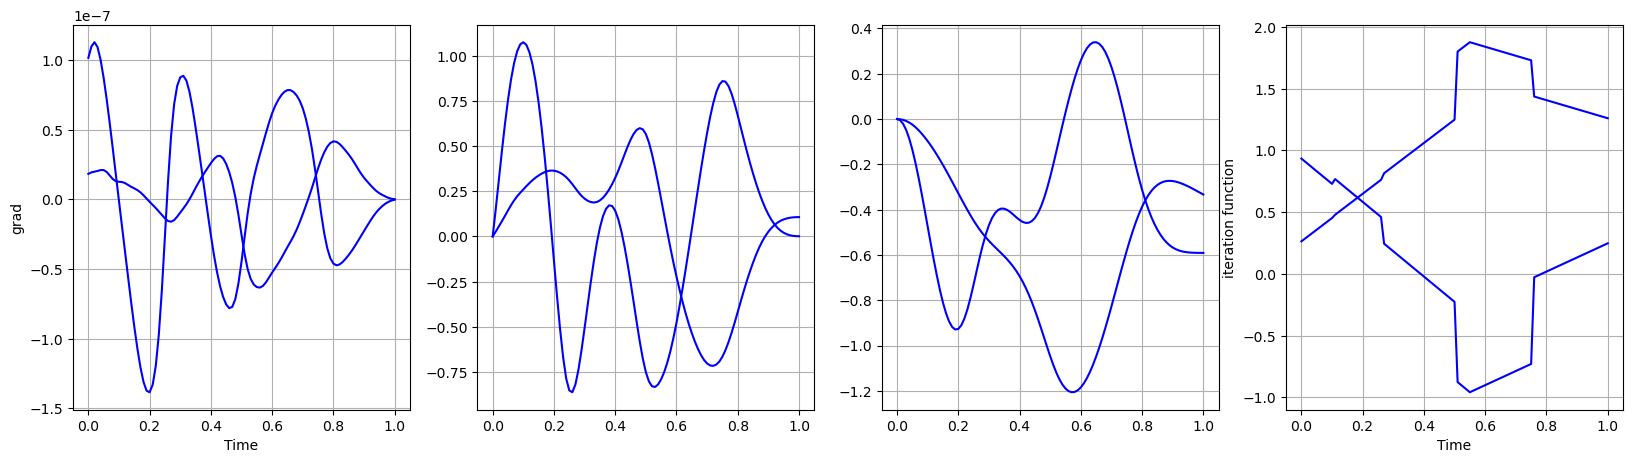

|p_max|/alpha:  1.1053326450017869 , |P_max|/beta:  1.2181911938226813
x_S:  0.1 x_K:  0.58 
New point: sigma= [-0.98895376  0.14822438] x_0 = 0.58 , type = 1
weights:  [3.38838953 0.82164751 0.0479517  0.77129771 0.21997446 0.
 0.90547948] slope:  [ 1.88110385 -1.96182404] y_shift [0.26462337 0.93212797]
7 : Active set:
	 0 sigma= [-0.54623822  0.83762987] ,	x_0 = 0.55 ,	type = 1 	weight: 3.388389527129509 	id: 140198480337504
	 1 sigma= [ 0.64608563 -0.76326494] ,	x_0 = 0.5 ,	type = 0 	weight: 0.8216475111486496 	id: 140198478886624
	 2 sigma= [0.12933423 0.99160106] ,	x_0 = 0.1 ,	type = 0 	weight: 0.047951697389919806 	id: 140198477552416
	 3 sigma= [-0.38299768  0.92374931] ,	x_0 = 0.75 ,	type = 0 	weight: 0.7712977086132105 	id: 140198477547760
	 4 sigma= [ 0.17218037 -0.98506544] ,	x_0 = 0.26 ,	type = 0 	weight: 0.21997445875284724 	id: 140198477287920
	 5 sigma= [-0.98895376  0.14822438] ,	x_0 = 0.58 ,	type = 1 	weight: 0.9054794813709428 	id: 140198449719360
slope:  [ 1.8811038

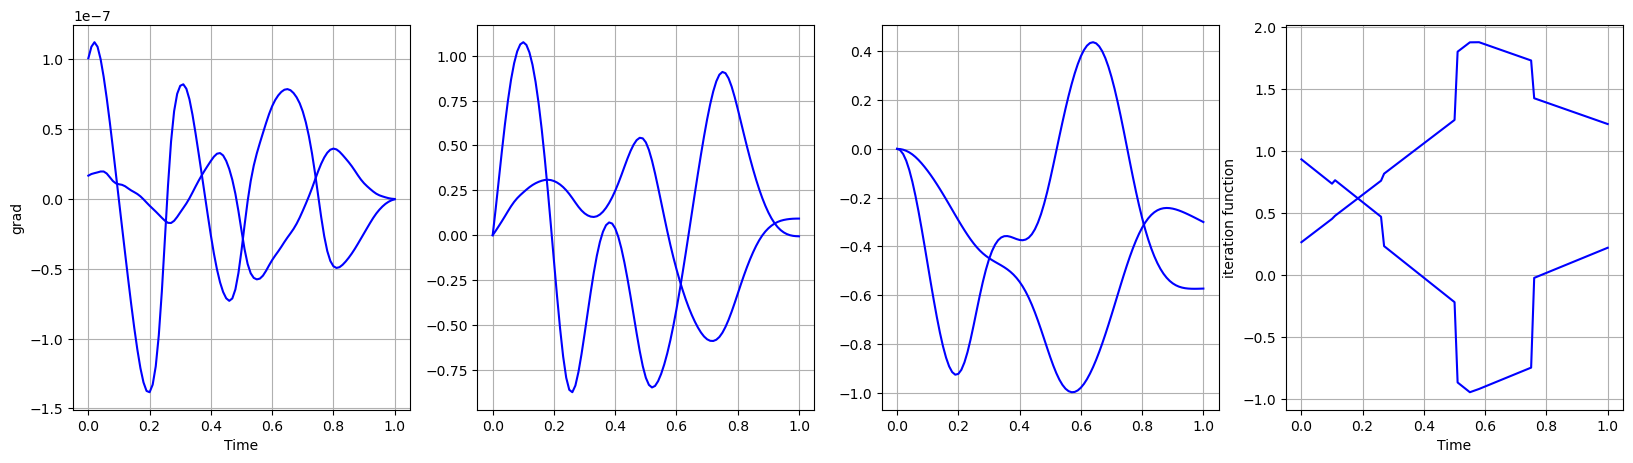

|p_max|/alpha:  1.1017845392841696 , |P_max|/beta:  1.050318004441529
x_S:  0.1 x_K:  0.6 
New point: sigma= [0.21672617 0.97623243] x_0 = 0.1 , type = 0
weights:  [3.38231069 0.82498379 0.         0.77036105 0.22224368 0.90019609
 0.04724245] slope:  [ 1.87176961 -1.95095963] y_shift [0.26342317 0.93177864]
8 : Active set:
	 0 sigma= [-0.54623822  0.83762987] ,	x_0 = 0.55 ,	type = 1 	weight: 3.382310687026668 	id: 140198480337504
	 1 sigma= [ 0.64608563 -0.76326494] ,	x_0 = 0.5 ,	type = 0 	weight: 0.8249837914662939 	id: 140198478886624
	 2 sigma= [-0.38299768  0.92374931] ,	x_0 = 0.75 ,	type = 0 	weight: 0.7703610473937892 	id: 140198477547760
	 3 sigma= [ 0.17218037 -0.98506544] ,	x_0 = 0.26 ,	type = 0 	weight: 0.22224368325767008 	id: 140198477287920
	 4 sigma= [-0.98895376  0.14822438] ,	x_0 = 0.58 ,	type = 1 	weight: 0.9001960896213242 	id: 140198449719360
	 5 sigma= [0.21672617 0.97623243] ,	x_0 = 0.1 ,	type = 0 	weight: 0.04724244818891367 	id: 140198446050400
slope:  [ 1.87176

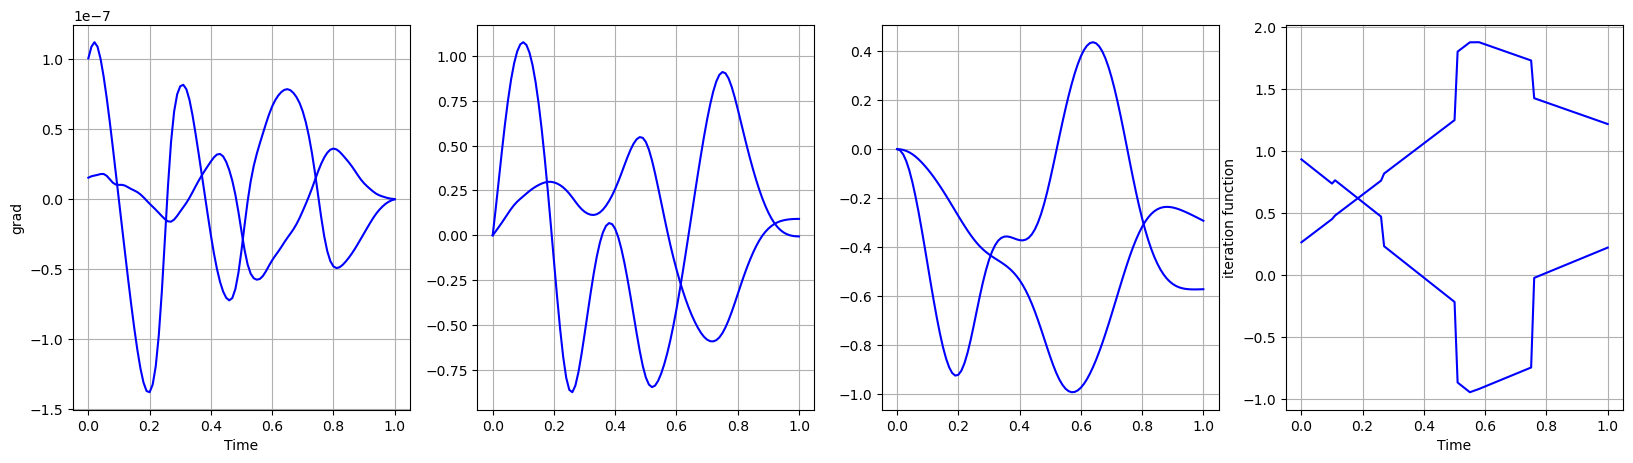

|p_max|/alpha:  1.09760206573147 , |P_max|/beta:  1.0463907228794507
x_S:  0.1 x_K:  0.6 
New point: sigma= [0.19834521 0.98013222] x_0 = 0.1 , type = 0
weights:  [3.38447879 0.82420968 0.77054156 0.22169791 0.90064765 0.
 0.04752668] slope:  [ 1.87378338 -1.95372744] y_shift [0.26364519 0.93180999]
9 : Active set:
	 0 sigma= [-0.54623822  0.83762987] ,	x_0 = 0.55 ,	type = 1 	weight: 3.3844787897319484 	id: 140198480337504
	 1 sigma= [ 0.64608563 -0.76326494] ,	x_0 = 0.5 ,	type = 0 	weight: 0.8242096758853963 	id: 140198478886624
	 2 sigma= [-0.38299768  0.92374931] ,	x_0 = 0.75 ,	type = 0 	weight: 0.7705415635818561 	id: 140198477547760
	 3 sigma= [ 0.17218037 -0.98506544] ,	x_0 = 0.26 ,	type = 0 	weight: 0.2216979143779937 	id: 140198477287920
	 4 sigma= [-0.98895376  0.14822438] ,	x_0 = 0.58 ,	type = 1 	weight: 0.9006476517915885 	id: 140198449719360
	 5 sigma= [0.19834521 0.98013222] ,	x_0 = 0.1 ,	type = 0 	weight: 0.047526683308617326 	id: 140198794150976
slope:  [ 1.87378338 -1.9

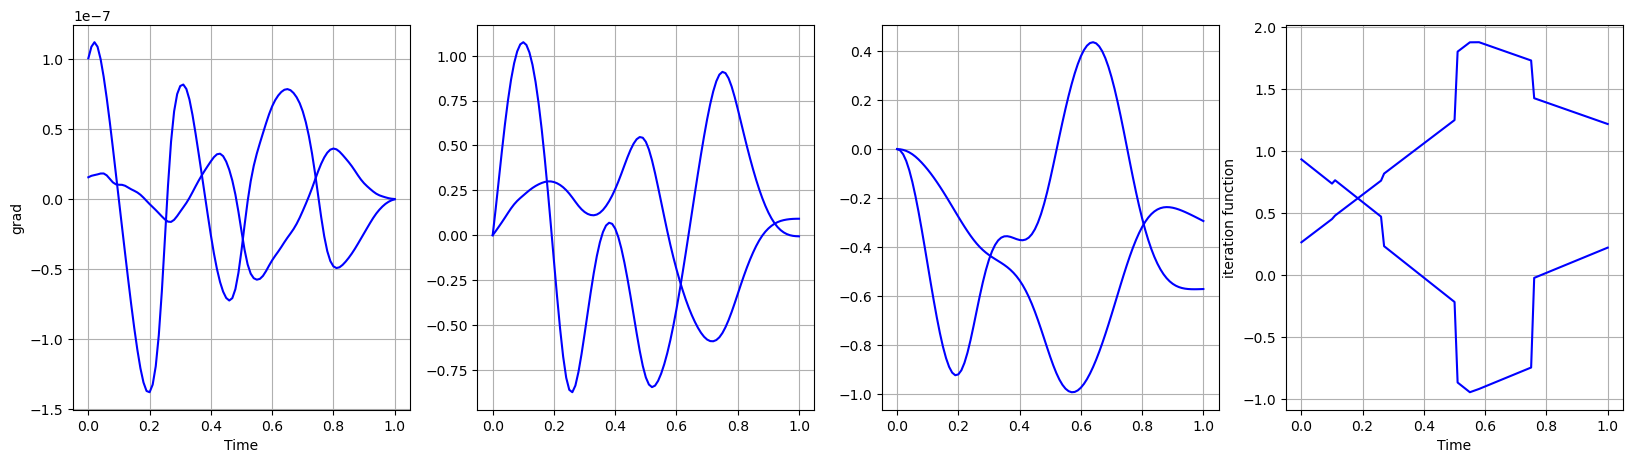

|p_max|/alpha:  1.097469449776019 , |P_max|/beta:  1.0472173534209999
x_S:  0.1 x_K:  0.6 
New point: sigma= [0.20195723 0.97939434] x_0 = 0.1 , type = 0
weights:  [3.38408828 0.82435916 0.77050537 0.2218026  0.90053152 0.
 0.04747628] slope:  [ 1.87338879 -1.95320218] y_shift [0.26360019 0.93180206]
10 : Active set:
	 0 sigma= [-0.54623822  0.83762987] ,	x_0 = 0.55 ,	type = 1 	weight: 3.384088278654955 	id: 140198480337504
	 1 sigma= [ 0.64608563 -0.76326494] ,	x_0 = 0.5 ,	type = 0 	weight: 0.8243591562203048 	id: 140198478886624
	 2 sigma= [-0.38299768  0.92374931] ,	x_0 = 0.75 ,	type = 0 	weight: 0.7705053650036225 	id: 140198477547760
	 3 sigma= [ 0.17218037 -0.98506544] ,	x_0 = 0.26 ,	type = 0 	weight: 0.22180260185695544 	id: 140198477287920
	 4 sigma= [-0.98895376  0.14822438] ,	x_0 = 0.58 ,	type = 1 	weight: 0.9005315236176924 	id: 140198449719360
	 5 sigma= [0.20195723 0.97939434] ,	x_0 = 0.1 ,	type = 0 	weight: 0.04747627585708403 	id: 140198449437520
slope:  [ 1.87338879 -1.

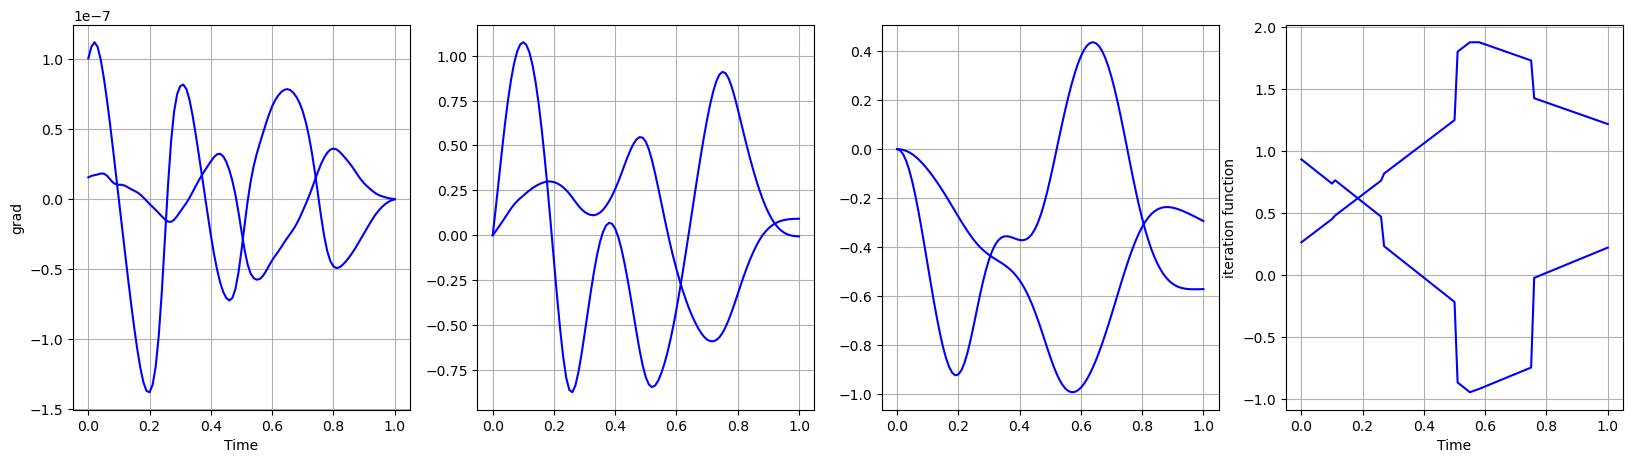

|p_max|/alpha:  1.0974536365811232 , |P_max|/beta:  1.04705446551692
x_S:  0.1 x_K:  0.6 
New point: sigma= [0.20123454 0.97954309] x_0 = 0.1 , type = 0
weights:  [3.38416784e+00 8.24329140e-01 7.70512578e-01 2.21781551e-01
 9.00553670e-01 5.10702591e-15 4.74865792e-02] slope:  [ 1.87346779 -1.95330803] y_shift [0.26360914 0.93180357]
11 : Active set:
	 0 sigma= [-0.54623822  0.83762987] ,	x_0 = 0.55 ,	type = 1 	weight: 3.3841678447461665 	id: 140198480337504
	 1 sigma= [ 0.64608563 -0.76326494] ,	x_0 = 0.5 ,	type = 0 	weight: 0.8243291400657677 	id: 140198478886624
	 2 sigma= [-0.38299768  0.92374931] ,	x_0 = 0.75 ,	type = 0 	weight: 0.770512577738911 	id: 140198477547760
	 3 sigma= [ 0.17218037 -0.98506544] ,	x_0 = 0.26 ,	type = 0 	weight: 0.2217815508624629 	id: 140198477287920
	 4 sigma= [-0.98895376  0.14822438] ,	x_0 = 0.58 ,	type = 1 	weight: 0.9005536695647064 	id: 140198449719360
	 5 sigma= [0.20195723 0.97939434] ,	x_0 = 0.1 ,	type = 0 	weight: 5.10702591327572e-15 	id: 14019

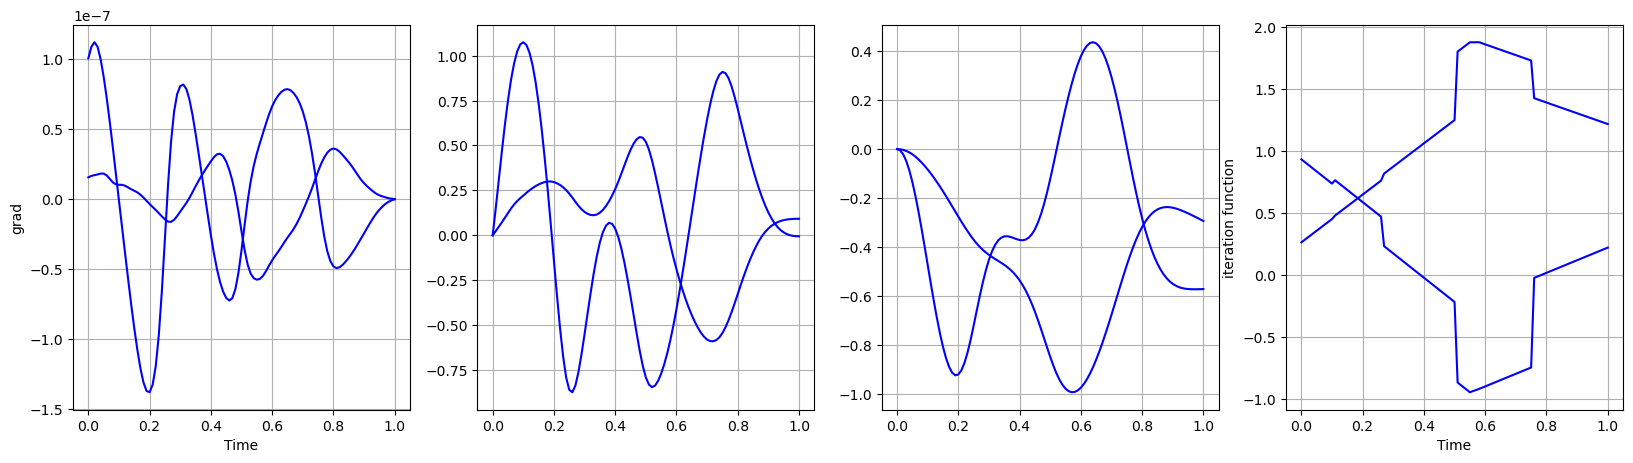

|p_max|/alpha:  1.0974551418476695 , |P_max|/beta:  1.0470870368174094
x_S:  0.1 x_K:  0.6 
New point: sigma= [0.20137864 0.97951347] x_0 = 0.1 , type = 0
weights:  [3.38415204e+00 8.24335121e-01 7.70511138e-01 2.21785744e-01
 9.00549210e-01 3.94239912e-15 0.00000000e+00 4.74845337e-02] slope:  [ 1.87345204 -1.95328695] y_shift [0.26360735 0.93180327]
12 : Active set:
	 0 sigma= [-0.54623822  0.83762987] ,	x_0 = 0.55 ,	type = 1 	weight: 3.384152037034395 	id: 140198480337504
	 1 sigma= [ 0.64608563 -0.76326494] ,	x_0 = 0.5 ,	type = 0 	weight: 0.8243351208068107 	id: 140198478886624
	 2 sigma= [-0.38299768  0.92374931] ,	x_0 = 0.75 ,	type = 0 	weight: 0.7705111384454785 	id: 140198477547760
	 3 sigma= [ 0.17218037 -0.98506544] ,	x_0 = 0.26 ,	type = 0 	weight: 0.22178574417151534 	id: 140198477287920
	 4 sigma= [-0.98895376  0.14822438] ,	x_0 = 0.58 ,	type = 1 	weight: 0.9005492095257804 	id: 140198449719360
	 5 sigma= [0.20195723 0.97939434] ,	x_0 = 0.1 ,	type = 0 	weight: 3.94239912050

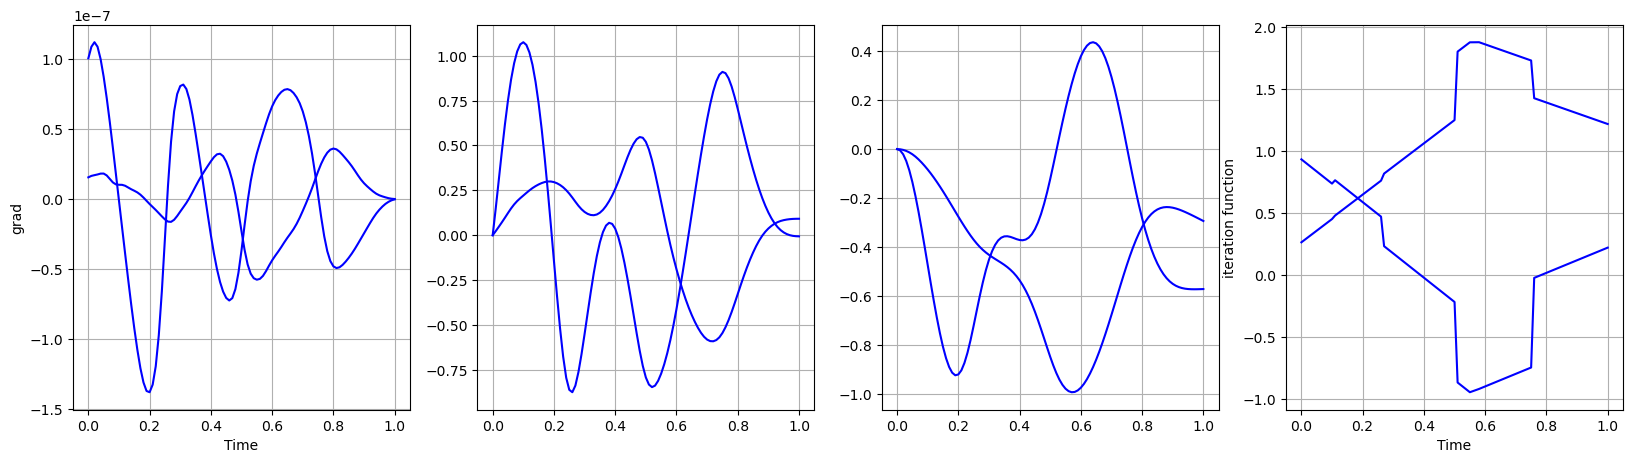

|p_max|/alpha:  1.0974547737106817 , |P_max|/beta:  1.0470805417340578
x_S:  0.1 x_K:  0.6 
New point: sigma= [0.20134989 0.97951938] x_0 = 0.1 , type = 0
weights:  [3.38415519e+00 8.24333927e-01 7.70511426e-01 2.21784907e-01
 9.00550098e-01 4.25193600e-15 0.00000000e+00 4.74849422e-02] slope:  [ 1.87345519 -1.95329116] y_shift [0.26360771 0.93180333]
13 : Active set:
	 0 sigma= [-0.54623822  0.83762987] ,	x_0 = 0.55 ,	type = 1 	weight: 3.384155193596376 	id: 140198480337504
	 1 sigma= [ 0.64608563 -0.76326494] ,	x_0 = 0.5 ,	type = 0 	weight: 0.8243339272502674 	id: 140198478886624
	 2 sigma= [-0.38299768  0.92374931] ,	x_0 = 0.75 ,	type = 0 	weight: 0.770511425590135 	id: 140198477547760
	 3 sigma= [ 0.17218037 -0.98506544] ,	x_0 = 0.26 ,	type = 0 	weight: 0.22178490727955538 	id: 140198477287920
	 4 sigma= [-0.98895376  0.14822438] ,	x_0 = 0.58 ,	type = 1 	weight: 0.900550097688071 	id: 140198449719360
	 5 sigma= [0.20195723 0.97939434] ,	x_0 = 0.1 ,	type = 0 	weight: 4.2519359952440

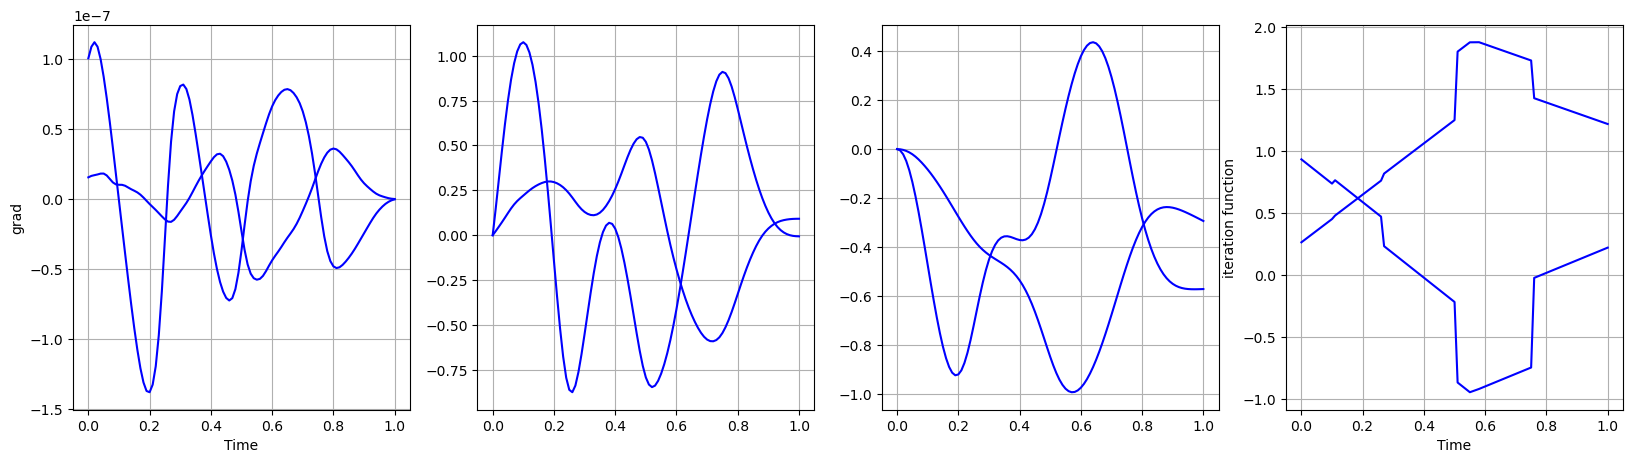

|p_max|/alpha:  1.09745484445106 , |P_max|/beta:  1.0470818377154432
x_S:  0.1 x_K:  0.6 
New point: sigma= [0.20135562 0.9795182 ] x_0 = 0.1 , type = 0
weights:  [3.38415456e+00 8.24334165e-01 7.70511368e-01 2.21785074e-01
 9.00549920e-01 4.18946788e-15 0.00000000e+00 4.74848607e-02] slope:  [ 1.87345456 -1.95329032] y_shift [0.26360764 0.93180332]
14 : Active set:
	 0 sigma= [-0.54623822  0.83762987] ,	x_0 = 0.55 ,	type = 1 	weight: 3.3841545639266815 	id: 140198480337504
	 1 sigma= [ 0.64608563 -0.76326494] ,	x_0 = 0.5 ,	type = 0 	weight: 0.8243341653684279 	id: 140198478886624
	 2 sigma= [-0.38299768  0.92374931] ,	x_0 = 0.75 ,	type = 0 	weight: 0.7705113683003635 	id: 140198477547760
	 3 sigma= [ 0.17218037 -0.98506544] ,	x_0 = 0.26 ,	type = 0 	weight: 0.22178507424019475 	id: 140198477287920
	 4 sigma= [-0.98895376  0.14822438] ,	x_0 = 0.58 ,	type = 1 	weight: 0.9005499204210616 	id: 140198449719360
	 5 sigma= [0.20195723 0.97939434] ,	x_0 = 0.1 ,	type = 0 	weight: 4.189467877866

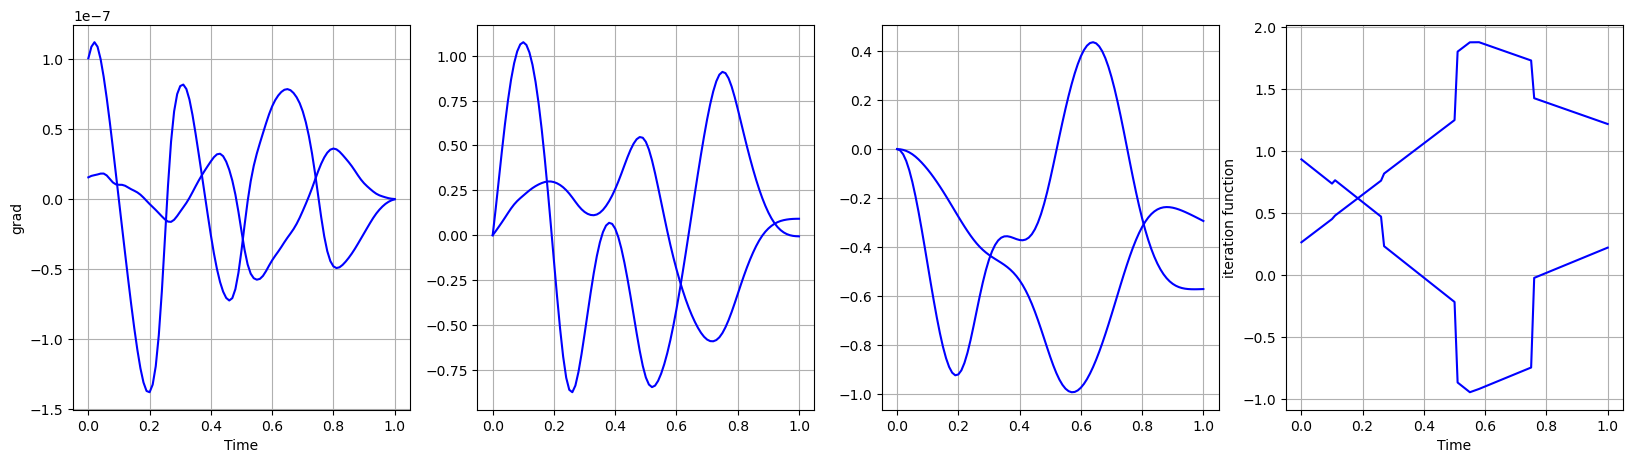

|p_max|/alpha:  1.097454830229399 , |P_max|/beta:  1.0470815791543586
x_S:  0.1 x_K:  0.6 
New point: sigma= [0.20135448 0.97951844] x_0 = 0.1 , type = 0
weights:  [3.38415469e+00 8.24334118e-01 7.70511380e-01 2.21785041e-01
 9.00549956e-01 4.20189578e-15 0.00000000e+00 4.74848770e-02] slope:  [ 1.87345468 -1.95329049] y_shift [0.26360765 0.93180332]
15 : Active set:
	 0 sigma= [-0.54623822  0.83762987] ,	x_0 = 0.55 ,	type = 1 	weight: 3.38415468955963 	id: 140198480337504
	 1 sigma= [ 0.64608563 -0.76326494] ,	x_0 = 0.5 ,	type = 0 	weight: 0.8243341178600436 	id: 140198478886624
	 2 sigma= [-0.38299768  0.92374931] ,	x_0 = 0.75 ,	type = 0 	weight: 0.7705113797303942 	id: 140198477547760
	 3 sigma= [ 0.17218037 -0.98506544] ,	x_0 = 0.26 ,	type = 0 	weight: 0.22178504092878576 	id: 140198477287920
	 4 sigma= [-0.98895376  0.14822438] ,	x_0 = 0.58 ,	type = 1 	weight: 0.9005499557848319 	id: 140198449719360
	 5 sigma= [0.20195723 0.97939434] ,	x_0 = 0.1 ,	type = 0 	weight: 4.2018957834970

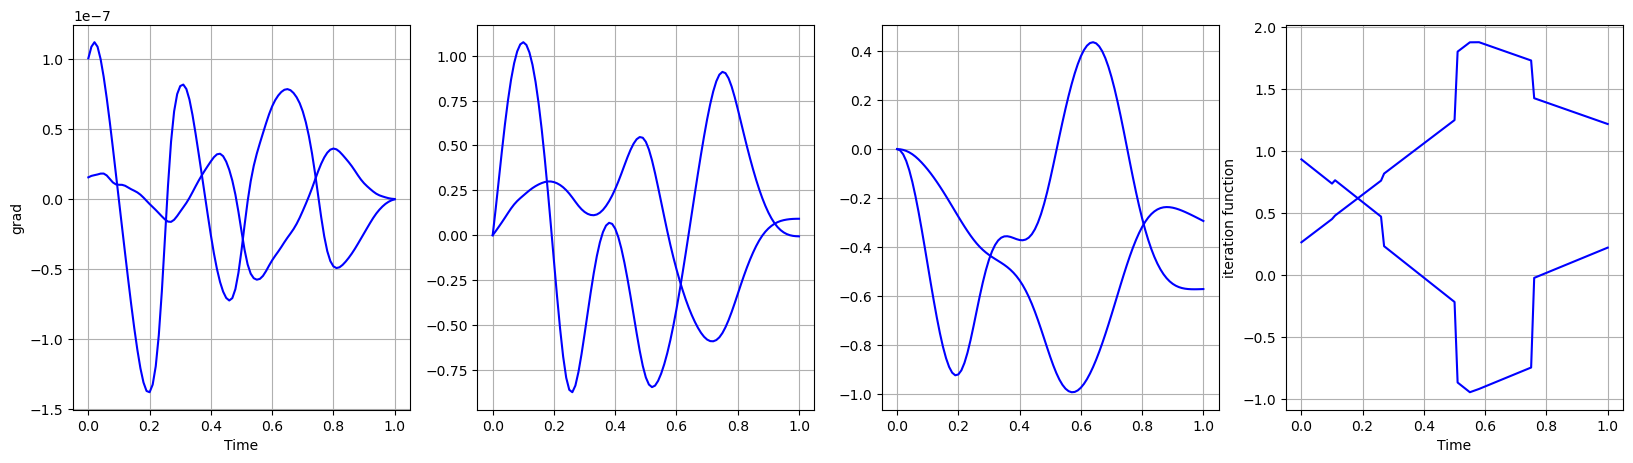

|p_max|/alpha:  1.0974548330615281 , |P_max|/beta:  1.0470816307414959
x_S:  0.1 x_K:  0.6 
New point: sigma= [0.20135471 0.97951839] x_0 = 0.1 , type = 0
weights:  [3.38415466e+00 8.24334127e-01 7.70511377e-01 2.21785048e-01
 9.00549949e-01 4.19941833e-15 0.00000000e+00 4.74848737e-02] slope:  [ 1.87345466 -1.95329046] y_shift [0.26360765 0.93180332]
16 : Active set:
	 0 sigma= [-0.54623822  0.83762987] ,	x_0 = 0.55 ,	type = 1 	weight: 3.3841546644938765 	id: 140198480337504
	 1 sigma= [ 0.64608563 -0.76326494] ,	x_0 = 0.5 ,	type = 0 	weight: 0.8243341273386202 	id: 140198478886624
	 2 sigma= [-0.38299768  0.92374931] ,	x_0 = 0.75 ,	type = 0 	weight: 0.7705113774499623 	id: 140198477547760
	 3 sigma= [ 0.17218037 -0.98506544] ,	x_0 = 0.26 ,	type = 0 	weight: 0.22178504757487547 	id: 140198477287920
	 4 sigma= [-0.98895376  0.14822438] ,	x_0 = 0.58 ,	type = 1 	weight: 0.900549948729543 	id: 140198449719360
	 5 sigma= [0.20195723 0.97939434] ,	x_0 = 0.1 ,	type = 0 	weight: 4.19941833124

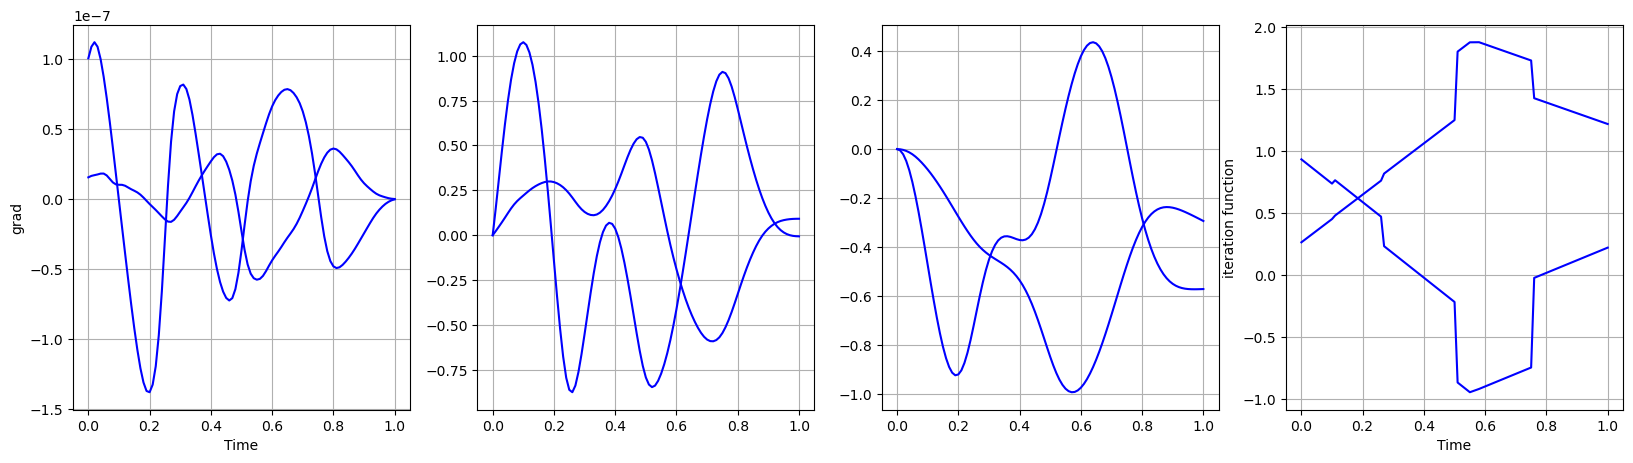

|p_max|/alpha:  1.097454832496924 , |P_max|/beta:  1.0470816204488356
x_S:  0.1 x_K:  0.6 
New point: sigma= [0.20135466 0.9795184 ] x_0 = 0.1 , type = 0
weights:  [3.38415467e+00 8.24334125e-01 7.70511378e-01 2.21785046e-01
 9.00549950e-01 4.19991119e-15 0.00000000e+00 4.74848744e-02] slope:  [ 1.87345466 -1.95329046] y_shift [0.26360765 0.93180332]
17 : Active set:
	 0 sigma= [-0.54623822  0.83762987] ,	x_0 = 0.55 ,	type = 1 	weight: 3.3841546694954285 	id: 140198480337504
	 1 sigma= [ 0.64608563 -0.76326494] ,	x_0 = 0.5 ,	type = 0 	weight: 0.824334125447496 	id: 140198478886624
	 2 sigma= [-0.38299768  0.92374931] ,	x_0 = 0.75 ,	type = 0 	weight: 0.7705113779048701 	id: 140198477547760
	 3 sigma= [ 0.17218037 -0.98506544] ,	x_0 = 0.26 ,	type = 0 	weight: 0.2217850462488502 	id: 140198477287920
	 4 sigma= [-0.98895376  0.14822438] ,	x_0 = 0.58 ,	type = 1 	weight: 0.9005499501368897 	id: 140198449719360
	 5 sigma= [0.20195723 0.97939434] ,	x_0 = 0.1 ,	type = 0 	weight: 4.1999111853016

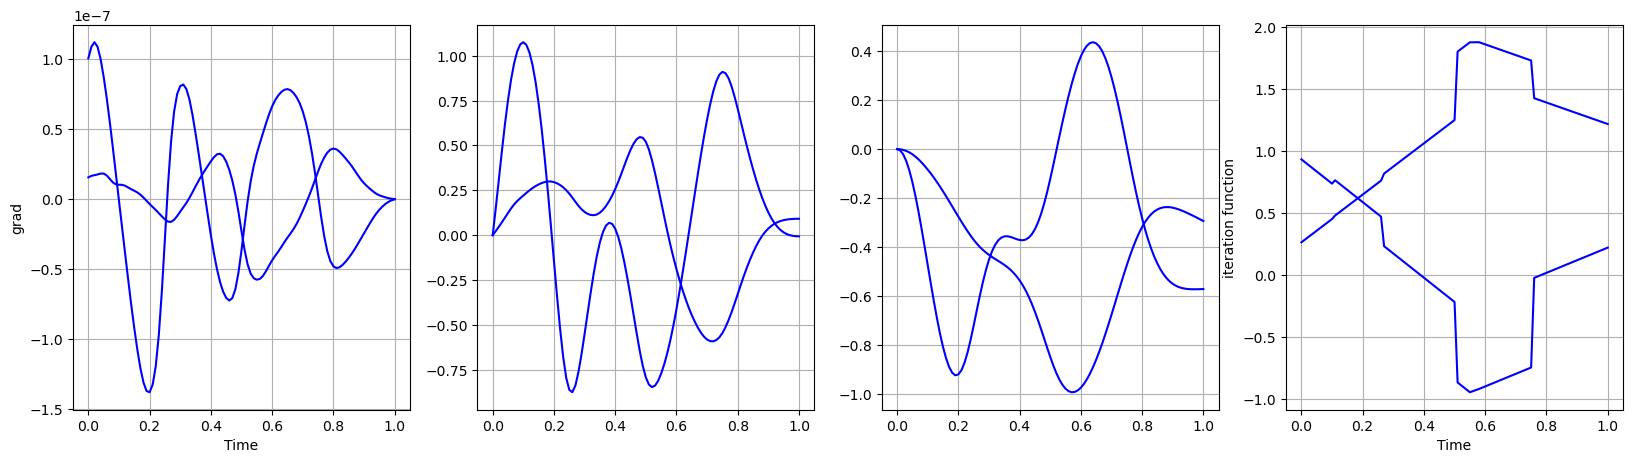

|p_max|/alpha:  1.0974548326093962 , |P_max|/beta:  1.0470816225022845
x_S:  0.1 x_K:  0.6 
New point: sigma= [0.20135467 0.9795184 ] x_0 = 0.1 , type = 0
weights:  [3.38415467e+00 8.24334126e-01 7.70511378e-01 2.21785047e-01
 9.00549950e-01 4.19981329e-15 0.00000000e+00 4.74848743e-02] slope:  [ 1.87345466 -1.95329046] y_shift [0.26360765 0.93180332]
18 : Active set:
	 0 sigma= [-0.54623822  0.83762987] ,	x_0 = 0.55 ,	type = 1 	weight: 3.384154668497414 	id: 140198480337504
	 1 sigma= [ 0.64608563 -0.76326494] ,	x_0 = 0.5 ,	type = 0 	weight: 0.8243341258247979 	id: 140198478886624
	 2 sigma= [-0.38299768  0.92374931] ,	x_0 = 0.75 ,	type = 0 	weight: 0.7705113778141459 	id: 140198477547760
	 3 sigma= [ 0.17218037 -0.98506544] ,	x_0 = 0.26 ,	type = 0 	weight: 0.22178504651340944 	id: 140198477287920
	 4 sigma= [-0.98895376  0.14822438] ,	x_0 = 0.58 ,	type = 1 	weight: 0.9005499498561423 	id: 140198449719360
	 5 sigma= [0.20195723 0.97939434] ,	x_0 = 0.1 ,	type = 0 	weight: 4.19981328682

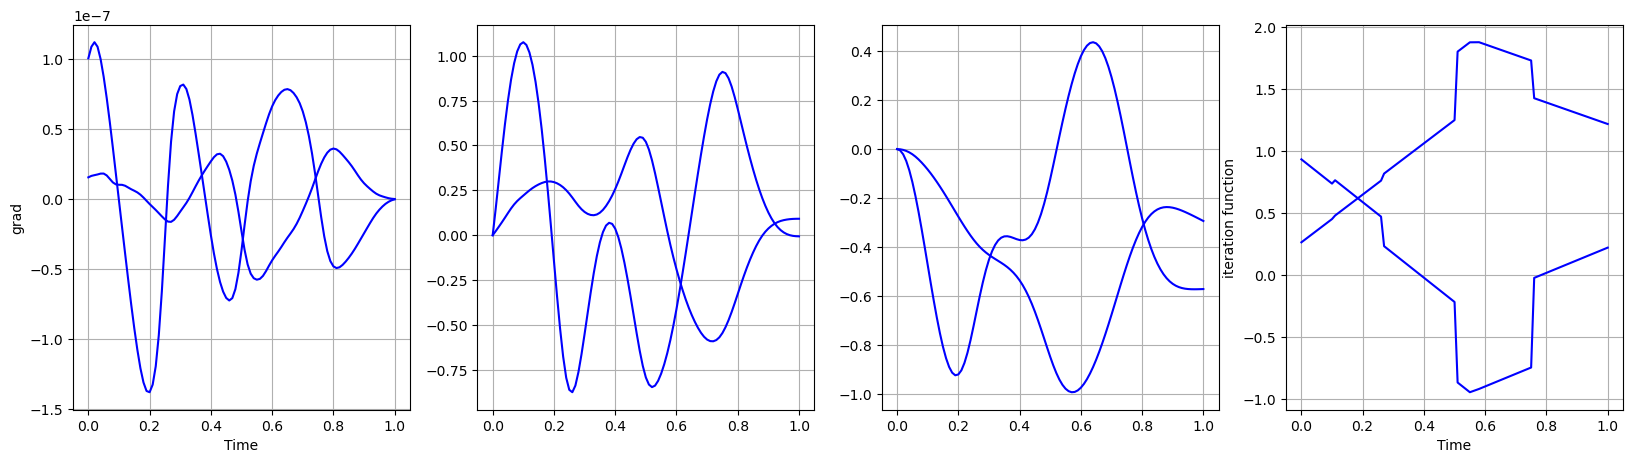

|p_max|/alpha:  1.0974548325870175 , |P_max|/beta:  1.0470816220927066
x_S:  0.1 x_K:  0.6 
New point: sigma= [0.20135467 0.9795184 ] x_0 = 0.1 , type = 0
weights:  [3.38415467e+00 8.24334126e-01 7.70511378e-01 2.21785046e-01
 9.00549950e-01 4.19983239e-15 0.00000000e+00 4.74848743e-02] slope:  [ 1.87345466 -1.95329046] y_shift [0.26360765 0.93180332]
19 : Active set:
	 0 sigma= [-0.54623822  0.83762987] ,	x_0 = 0.55 ,	type = 1 	weight: 3.384154668695224 	id: 140198480337504
	 1 sigma= [ 0.64608563 -0.76326494] ,	x_0 = 0.5 ,	type = 0 	weight: 0.8243341257495287 	id: 140198478886624
	 2 sigma= [-0.38299768  0.92374931] ,	x_0 = 0.75 ,	type = 0 	weight: 0.7705113778324135 	id: 140198477547760
	 3 sigma= [ 0.17218037 -0.98506544] ,	x_0 = 0.26 ,	type = 0 	weight: 0.22178504646071695 	id: 140198477287920
	 4 sigma= [-0.98895376  0.14822438] ,	x_0 = 0.58 ,	type = 1 	weight: 0.9005499499126952 	id: 140198449719360
	 5 sigma= [0.20195723 0.97939434] ,	x_0 = 0.1 ,	type = 0 	weight: 4.19983239138

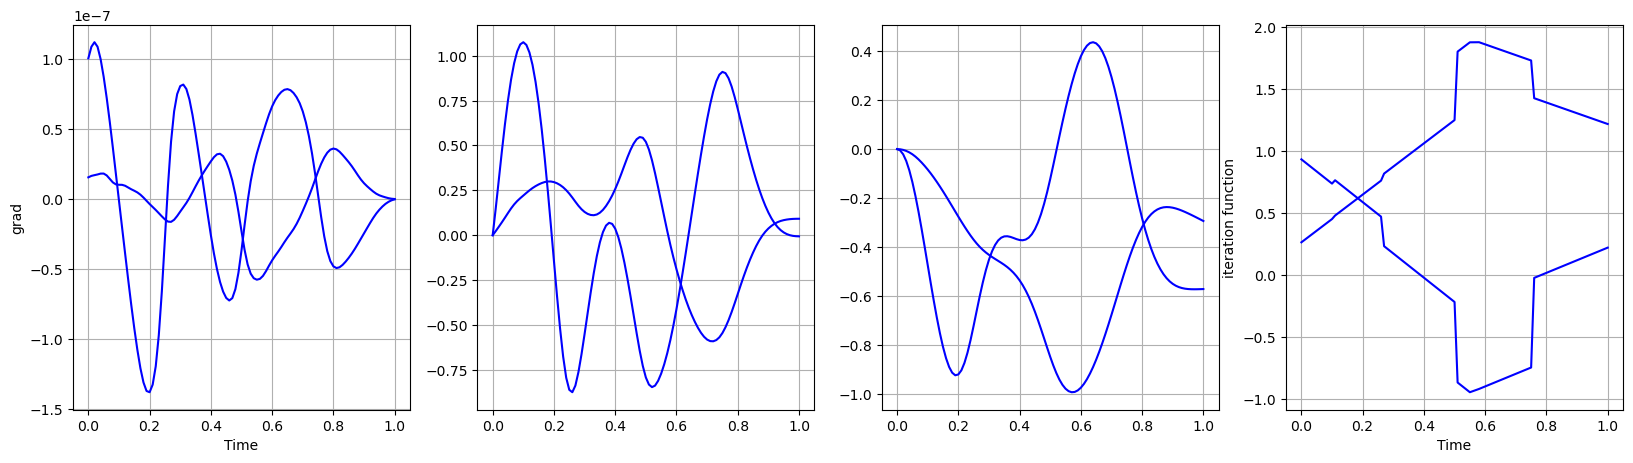

|p_max|/alpha:  1.0974548325913025 , |P_max|/beta:  1.0470816221743258
x_S:  0.1 x_K:  0.6 
New point: sigma= [0.20135467 0.9795184 ] x_0 = 0.1 , type = 0
weights:  [3.38415467e+00 8.24334126e-01 7.70511378e-01 2.21785046e-01
 9.00549950e-01 4.19983379e-15 0.00000000e+00 4.74848743e-02] slope:  [ 1.87345466 -1.95329046] y_shift [0.26360765 0.93180332]
20 : Active set:
	 0 sigma= [-0.54623822  0.83762987] ,	x_0 = 0.55 ,	type = 1 	weight: 3.3841546686562887 	id: 140198480337504
	 1 sigma= [ 0.64608563 -0.76326494] ,	x_0 = 0.5 ,	type = 0 	weight: 0.8243341257646256 	id: 140198478886624
	 2 sigma= [-0.38299768  0.92374931] ,	x_0 = 0.75 ,	type = 0 	weight: 0.7705113778285984 	id: 140198477547760
	 3 sigma= [ 0.17218037 -0.98506544] ,	x_0 = 0.26 ,	type = 0 	weight: 0.221785046471218 	id: 140198477287920
	 4 sigma= [-0.98895376  0.14822438] ,	x_0 = 0.58 ,	type = 1 	weight: 0.9005499499014369 	id: 140198449719360
	 5 sigma= [0.20195723 0.97939434] ,	x_0 = 0.1 ,	type = 0 	weight: 4.199833787666

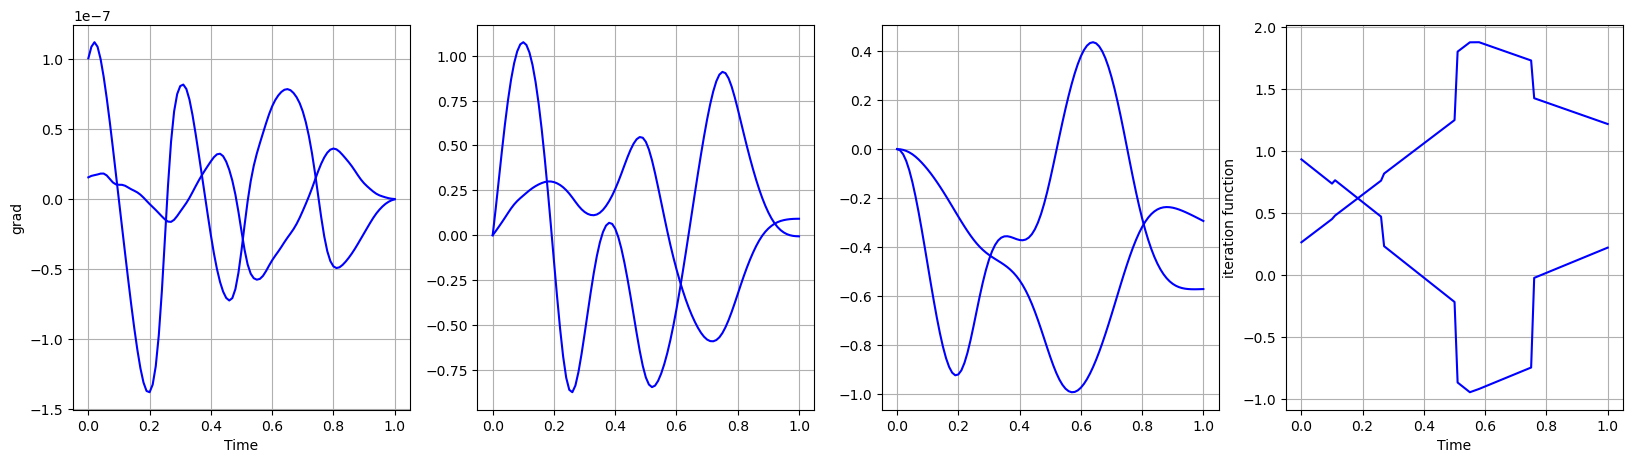

|p_max|/alpha:  1.0974548325913385 , |P_max|/beta:  1.0470816221581367
x_S:  0.1 x_K:  0.6 
New point: sigma= [0.20135467 0.9795184 ] x_0 = 0.1 , type = 0
weights:  [3.38415467e+00 8.24334126e-01 7.70511378e-01 2.21785046e-01
 9.00549950e-01 4.19982792e-15 0.00000000e+00 4.74848743e-02] slope:  [ 1.87345466 -1.95329046] y_shift [0.26360765 0.93180332]
21 : Active set:
	 0 sigma= [-0.54623822  0.83762987] ,	x_0 = 0.55 ,	type = 1 	weight: 3.3841546686646855 	id: 140198480337504
	 1 sigma= [ 0.64608563 -0.76326494] ,	x_0 = 0.5 ,	type = 0 	weight: 0.8243341257615441 	id: 140198478886624
	 2 sigma= [-0.38299768  0.92374931] ,	x_0 = 0.75 ,	type = 0 	weight: 0.7705113778293744 	id: 140198477547760
	 3 sigma= [ 0.17218037 -0.98506544] ,	x_0 = 0.26 ,	type = 0 	weight: 0.22178504646906094 	id: 140198477287920
	 4 sigma= [-0.98895376  0.14822438] ,	x_0 = 0.58 ,	type = 1 	weight: 0.900549949903152 	id: 140198449719360
	 5 sigma= [0.20195723 0.97939434] ,	x_0 = 0.1 ,	type = 0 	weight: 4.19982791799

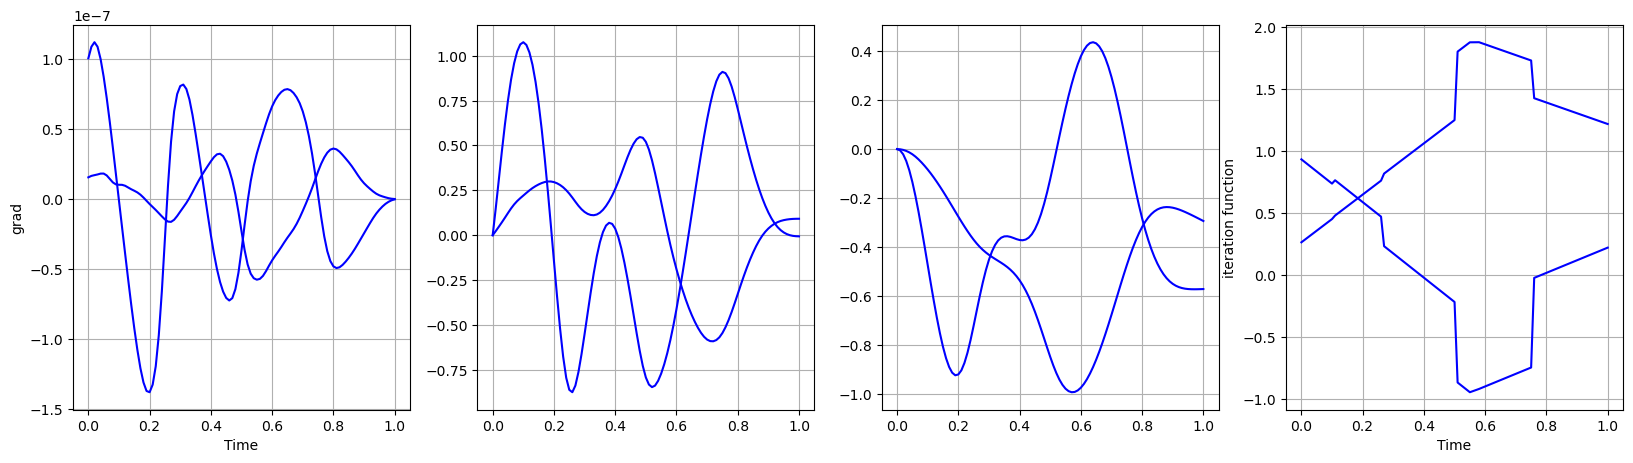

|p_max|/alpha:  1.0974548325906095 , |P_max|/beta:  1.04708162216178
x_S:  0.1 x_K:  0.6 
New point: sigma= [0.20135467 0.9795184 ] x_0 = 0.1 , type = 0
weights:  [3.38415467e+00 8.24334126e-01 7.70511378e-01 2.21785046e-01
 9.00549950e-01 4.19983420e-15 0.00000000e+00 4.74848743e-02] slope:  [ 1.87345466 -1.95329046] y_shift [0.26360765 0.93180332]
22 : Active set:
	 0 sigma= [-0.54623822  0.83762987] ,	x_0 = 0.55 ,	type = 1 	weight: 3.3841546686619406 	id: 140198480337504
	 1 sigma= [ 0.64608563 -0.76326494] ,	x_0 = 0.5 ,	type = 0 	weight: 0.8243341257621717 	id: 140198478886624
	 2 sigma= [-0.38299768  0.92374931] ,	x_0 = 0.75 ,	type = 0 	weight: 0.7705113778293131 	id: 140198477547760
	 3 sigma= [ 0.17218037 -0.98506544] ,	x_0 = 0.26 ,	type = 0 	weight: 0.22178504646954303 	id: 140198477287920
	 4 sigma= [-0.98895376  0.14822438] ,	x_0 = 0.58 ,	type = 1 	weight: 0.9005499499034529 	id: 140198449719360
	 5 sigma= [0.20195723 0.97939434] ,	x_0 = 0.1 ,	type = 0 	weight: 4.199834204565

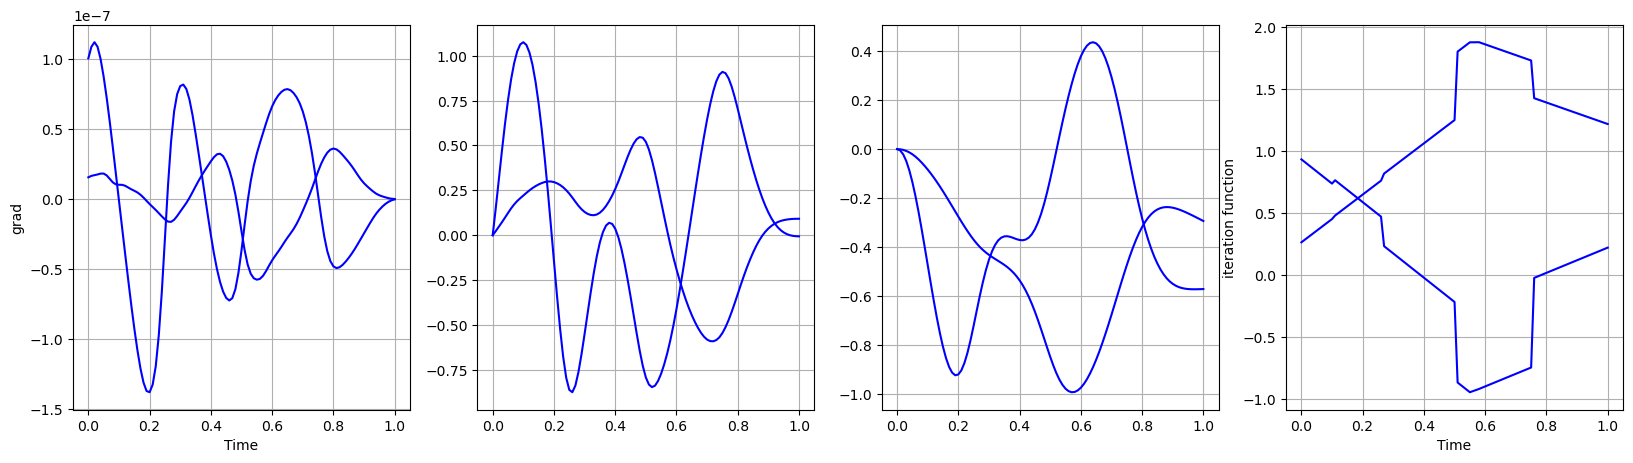

|p_max|/alpha:  1.097454832591314 , |P_max|/beta:  1.0470816221613122


In [ ]:
def testRegularizationParameters(alpha, beta, params, originalSignal):
    params.alpha = alpha
    params.beta = beta
    print('Test for alpha=', alpha, ', beta=', beta)
    active_set = []
    weights = np.ones(len(active_set))
    slope = np.ones(params.d)
    y_shift = np.ones(params.d)    
    active_set, weights, slope, y_shift, constraintViolation, sizeActiveSet = algorithm(active_set, weights, slope, y_shift, params)
    printIterationInfo(0, active_set, weights, slope, y_shift, np.identity(1))
    timePoints = np.linspace(0, params.T, num=int(params.T/params.dt))
    u_fin = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)
    reconstruction = np.array([u_fin(t) for t in timePoints])
    fig, (ax1, ax2) = mpl.pyplot.subplots(1, 2, figsize=(10, 5))
    
    ax1.plot(timePoints, originalSignal[:, 0], label='u(t)')
    ax1.plot(timePoints, reconstruction[:, 0], label='$\tilde{u}(t)$')
    ax2.plot(timePoints, originalSignal[:, 1], label='u(t)')
    ax2.plot(timePoints, reconstruction[:, 1], label='$\tilde{u}(t)$')
    mpl.pyplot.show()
    fig, (ax3, ax4) = mpl.pyplot.subplots(1, 2, figsize=(10, 5))
    plot_array(constraintViolation, T=len(constraintViolation), label='Constraint violation', ax=ax3)
    ax3.set_yscale('log')
    plot_array(sizeActiveSet, T=len(sizeActiveSet), label='Size active set', ax=ax4)
    mpl.pyplot.show()

params.maxIterations = 40
params.newton_c = 1
params.maxNewtonSteps = 50
params.pruneThreshold = 0
params.verbose = True
params.mollify_const = 0.01
params.solver = computeSSNStepWalter

s1 = lambda t: (2*t+0.25 if t < 0.25 else(1.3*t + 0.5 if t < 0.5 else (-t+2.5 if t < 0.75 else 1.25)))
#s1 = lambda t : (0.05 if t <= 0.25 else (0.65 if t <= 0.5 else (0.15 if t <= 0.75 else 0.35)))
#s1 = lambda t : (0.05*t if t <= 0.25 else (0.90*t + 1 if t <= 0.5 else -2 - 0.95*t if t <= 0.75 else 0.3)) #/ params.alpha
s2 = lambda t : (0.775 if t <= 0.25 else (0.025 if t <= 0.5 else (-0.975 if t <= 0.75 else 0.275)))
setupObservation(s1, s2, params)

g1 = getSourceTerm(params.x1, params)
g2 = getSourceTerm(params.x2, params)
#gradient_test = buildControlFunctionAdjoint([g1, g2], solveAdjointEquation(params.yd, params), params)
timePoints = np.linspace(0, params.T, num=int(params.T/params.dt))
array = np.ndarray((int(params.T/params.dt), 2))
array[:, 0] = np.array([s1(t) for t in timePoints])
array[:, 1] = np.array([s2(t) for t in timePoints])
plot_array(array, params.T)

testRegularizationParameters(7e-9, 1e-9, params, array)
#testRegularizationParameters(1e-8, 1e-6, params, array)
#testRegularizationParameters(5e-8, 1e-8, params, array)